In [1]:
# 1.序列模型
from IPython import display
import matplotlib.pyplot as plt
def use_svg_display():
    # 使用 svg 格式在 jupyter 中绘图
    display.set_matplotlib_formats('svg')
def set_figsize(figsize = (3.5, 2.5)):
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴。"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, 
         xlim=None, ylim=None, xscale='linear', yscale='linear', 
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点。"""
    if legend is None:
        legend = []
    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()
    # 如果 `X` 有⼀个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or 
                isinstance(X, list) and not hasattr(X[0], "__len__"))
    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [2]:
from torch.utils import data
def load_array(data_arrays, batch_size, is_train = True): 
    """构造一个 Pytorch 数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(
        dataset, batch_size, shuffle = is_train)

In [3]:
class Accumulator:  #@save
    """在 n 个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上的模型损失"""
    metric = d2l.Accumulator(2)  # 损失的总和，样本数量
    for x, y in data_iter:
        out = net(x)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [80]:
import time
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累积时间"""
        return np.array(self.times).cumsum().tolist()

In [5]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [6]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel = None, ylabel = None, 
                 legend = None, xlim = None, ylim = None, 
                 xscale = 'linear', yscale = 'linear', 
                 fmts = ('-', 'm--', 'g-.', 'r:'), 
                 nrows = 1, ncols = 1,  figsize = (3.5, 2.5)):
        """增量的绘制多条线"""
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize = figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, 
                                                xscale, yscale, legend)
        self.x, self.y, self.fmts = None, None, fmts
    def add(self, x, y):
        """向表中添加多个数据点"""
        if not hasattr(y, '__len__'):
            y = [y]
        n = len(y)
        if not hasattr(x, '__len__'):
            x = [x] * n
        if not self.x:
            self.x = [[] for _ in range(n)]
        if not self.y:
            self.y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.x[i].append(a)
                self.y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.x, self.y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait = True)

In [7]:
def try_gpu(i = 0):  #@save
    """如果存在，则返回 gpu(i)，否则返回 cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device('cpu')

In [8]:
# 训练
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
T = 1000  # 总共产生 1000 个点
time = torch.arange(1, T + 1, dtype = torch.float32)
# time = tensor([1., 2., ...., 1000.])
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
time.shape, x.shape

(torch.Size([1000]), torch.Size([1000]))

C:\Users\hasee\AppData\Local\Temp/ipykernel_1492/1272709441.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


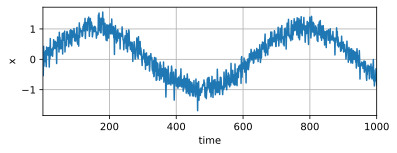

In [10]:
plot(time, [x], 'time', 'x', xlim = [1, 1000], figsize = (6, 2))

In [11]:
tau = 4
features = torch.zeros((T - tau, tau))
features, features.shape

(tensor([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
 torch.Size([996, 4]))

In [12]:
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
features, features.shape

(tensor([[ 0.0195, -0.5370,  0.4264, -0.2232],
         [-0.5370,  0.4264, -0.2232,  0.2383],
         [ 0.4264, -0.2232,  0.2383,  0.0386],
         ...,
         [-0.5594, -0.7169, -0.6988, -0.4653],
         [-0.7169, -0.6988, -0.4653, -0.3090],
         [-0.6988, -0.4653, -0.3090, -0.6312]]),
 torch.Size([996, 4]))

In [13]:
labels = x[tau:].reshape((-1, 1))
labels.shape

torch.Size([996, 1])

In [14]:
batch_size, n_train = 16, 600

In [15]:
train_iter = load_array(
    (features[:n_train], labels[:n_train]), 
    batch_size, is_train = True)

In [16]:
# 初始化网络权重参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

In [17]:
# 平方损失
loss = nn.MSELoss()

In [18]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for x, y in train_iter:
            trainer.zero_grad()
            l = loss(net(x), y)
            l.backward()
            trainer.step()
        print(f"epoch:{epoch + 1:.5f}, \
              loss:{evaluate_loss(net, train_iter, loss):.5f}")

In [19]:
net = get_net()

In [20]:
train(net, train_iter, loss, 5, 0.01)

epoch:1.00000,               loss:0.09909
epoch:2.00000,               loss:0.06450
epoch:3.00000,               loss:0.06325
epoch:4.00000,               loss:0.05917
epoch:5.00000,               loss:0.05994


In [21]:
# 预测
onestep_preds = net(features)
onestep_preds.shape

torch.Size([996, 1])

C:\Users\hasee\AppData\Local\Temp/ipykernel_1492/1272709441.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


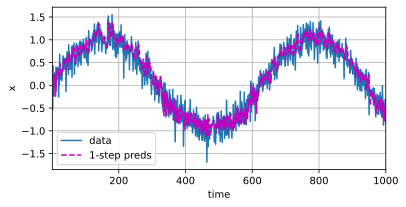

In [22]:
plot([time, time[tau:]], 
     [x.detach().numpy(), onestep_preds.detach().numpy()], 
     'time', 'x', 
     legend = ['data', '1-step preds'], 
     xlim = [1, 1000], 
     figsize = (6, 3))

In [23]:
multistep_preds = torch.zeros(T)
multistep_preds.shape, x.shape

(torch.Size([1000]), torch.Size([1000]))

In [24]:
# n_train = 600
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

C:\Users\hasee\AppData\Local\Temp/ipykernel_1492/1272709441.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


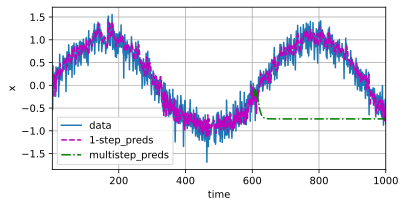

In [25]:
plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(), 
    onestep_preds.detach().numpy(), 
    multistep_preds[n_train + tau:].detach().numpy()], 
     'time', 'x', 
     legend = ['data', '1-step_preds', 'multistep_preds'],
     xlim = [1, 1000], figsize = (6, 3))

In [26]:
max_steps = 64

In [27]:
features = torch.zeros((
    T - tau - max_steps + 1, tau + max_steps))
features.shape

torch.Size([933, 68])

In [28]:
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]
features.shape

torch.Size([933, 68])

In [29]:
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau : i]).reshape(-1)
features.shape

torch.Size([933, 68])

In [30]:
steps = (1, 4, 16, 64)

C:\Users\hasee\AppData\Local\Temp/ipykernel_1492/1272709441.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


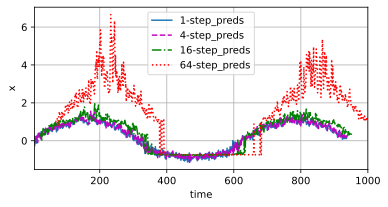

In [31]:
plot([time[tau + i - 1:T - max_steps + i] for i in steps], 
     [features[:, (tau + i - 1)].detach().numpy() 
      for i in steps], 
     'time', 'x', 
     legend = [f"{i}-step_preds" for i in steps], 
     xlim = [5, 1000], 
     figsize = (6, 3))

In [32]:
# 2.文本预处理
# 下⾯的 download 函数⽤来下载数据集，将数据集缓存在本地⽬录（默认情况下为../data）中，并返回下载⽂件的名称
import os
import requests
import hashlib
def download(name, cache_dir=os.path.join('C:/Users/hasee/Desktop/cvtf', 'data')): #@save
    """下载⼀个DATA_HUB中的⽂件，返回本地⽂件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok = True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # Hit cache
    print(f'正在从{url}下载{fname}...') 
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [33]:
import collections
import re
from d2l import torch as d2l

In [34]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [35]:
# 读取数据集(将文本作为字符串加载到内存中)
DATA_HUB['time_machine'] = (
    DATA_URL + 'timemachine.txt', 
    '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine(): #@save
    """Load the time machine dataset into a list of text lines."""
    with open(download('time_machine'), 'r') as f:
        lines = f.readlines()  # 读取每一行
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() 
            for line in lines]
lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [36]:
# 标记化(将字符串拆分成标记)
def tokenize(lines, token='word'): #@save
    """将⽂本⾏拆分为单词或字符标记。"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知令牌类型：' + token)
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [37]:
class Vocab:
    """文本词表"""
    def __init__(self, tokens = None, min_freq = 0, 
                 reserved_tokens = None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self.token_freqs = sorted(
            counter.items(), key = lambda x:x[1], reverse = True)
        # 未知标记的索引为零
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs 
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
# 建立一个词汇表，将拆分的标记映射到数字索引
def count_corpus(tokens):
    """统计标记的频率"""
    # 这里 tokens 是 1D 或者 2D 列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将标记列表展平成使用标记填充的一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [38]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:30])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9), ('my', 10), ('it', 11), ('had', 12), ('me', 13), ('as', 14), ('at', 15), ('for', 16), ('with', 17), ('but', 18), ('time', 19), ('were', 20), ('this', 21), ('you', 22), ('on', 23), ('then', 24), ('his', 25), ('there', 26), ('he', 27), ('have', 28), ('they', 29)]


In [39]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [40]:
# 将文本转换为数字索引序列
def load_corpus_time_machine(max_tokens = -1):  #@save
    """返回时光机器数据集的标记索引列表和词汇表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    """因为时光机器数据集中的每一个文本行，不一定是一个句子或者一个段落"""
    """所以将所有文本行展开到一个列表中"""
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [41]:
corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

In [42]:
# 3.语言模型和数据集
# 自然语言统计
import random
import torch
from d2l import torch as d2l

In [43]:
tokens = tokenize(read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[:10]  # 按顺序排序

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

C:\Users\hasee\AppData\Local\Temp/ipykernel_1492/1272709441.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


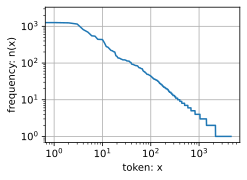

In [44]:
freqs = [freq for token, freq in vocab.token_freqs]
plot(freqs, xlabel = 'token: x', ylabel = 'frequency: n(x)', 
     xscale = 'log', yscale = 'log')

In [45]:
# 二元语法
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [46]:
# 三元语法
trigram_tokens = [triple for triple in 
                  zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

C:\Users\hasee\AppData\Local\Temp/ipykernel_1492/1272709441.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


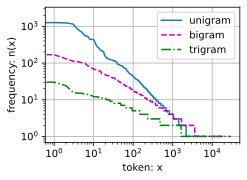

In [47]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
plot([freqs, bigram_freqs, trigram_freqs], 
     xlabel = 'token: x', ylabel = 'frequency: n(x)', 
     xscale = 'log', yscale = 'log', 
     legend = ['unigram', 'bigram', 'trigram'])

In [48]:
# 读取长序列数据
# 随机采样
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量序列"""
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为 num_steps 的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, 
                                 num_steps))
    # 在随机抽样的迭代过程中
    # 来自两个相邻的，随机的，小批量的子序列比一定在原始序列上相邻
    random.shuffle(initial_indices)
    def data(pos):
        # 返回 pos 位置开始的长度为 num_steps 的序列
        return corpus[pos:pos + num_steps]
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[
            i:i + batch_size]
        x = [data(j) for j in initial_indices_per_batch]
        y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(x), torch.tensor(y)

In [49]:
my_seq = list(range(35))
for x, y in seq_data_iter_random(
    my_seq, batch_size = 2, num_steps = 5):
    print('x:', x, '\ny:', y)

x: tensor([[ 8,  9, 10, 11, 12],
        [ 3,  4,  5,  6,  7]]) 
y: tensor([[ 9, 10, 11, 12, 13],
        [ 4,  5,  6,  7,  8]])
x: tensor([[23, 24, 25, 26, 27],
        [13, 14, 15, 16, 17]]) 
y: tensor([[24, 25, 26, 27, 28],
        [14, 15, 16, 17, 18]])
x: tensor([[28, 29, 30, 31, 32],
        [18, 19, 20, 21, 22]]) 
y: tensor([[29, 30, 31, 32, 33],
        [19, 20, 21, 22, 23]])


In [50]:
# 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量序列"""
    """从随机偏移量开始划分序列"""
    offset = random.randint(0, num_steps)
    num_tokens = (
        (len(corpus) - offset - 1) // batch_size) * batch_size
    xs = torch.tensor(corpus[offset:offset + num_tokens])
    ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    xs, ys = xs.reshape(batch_size, -1), ys.reshape(batch_size, -1)
    num_batches = xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        x = xs[:, i:i + num_steps]
        y = ys[:, i:i + num_steps]
        yield x, y

In [51]:
for x, y in seq_data_iter_sequential(
    my_seq, batch_size = 2, num_steps = 5):
    print('x:', x, '\ny:', y)

x: tensor([[ 0,  1,  2,  3,  4],
        [17, 18, 19, 20, 21]]) 
y: tensor([[ 1,  2,  3,  4,  5],
        [18, 19, 20, 21, 22]])
x: tensor([[ 5,  6,  7,  8,  9],
        [22, 23, 24, 25, 26]]) 
y: tensor([[ 6,  7,  8,  9, 10],
        [23, 24, 25, 26, 27]])
x: tensor([[10, 11, 12, 13, 14],
        [27, 28, 29, 30, 31]]) 
y: tensor([[11, 12, 13, 14, 15],
        [28, 29, 30, 31, 32]])


In [52]:
# 我们将上面的两个采样函数包装到一个类中，以便稍后可以将其用作数据迭代器
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(
        self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(
            max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    def __iter__(self):
        return self.data_iter_fn(
            self.corpus, self.batch_size, self.num_steps)

In [53]:
# 返回数据迭代器和词汇表，类似于 load_data_fashion_mnist 
def load_data_time_machine(
    batch_size, num_steps, use_random_iter = False, 
    max_tokens = 10000):
    """返回时光机器数据集的迭代器和词汇表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [54]:
# 4.循环神经网络
# 具有隐藏状态的的循环神经网络
import torch
from d2l import torch as d2l

In [55]:
x, w_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
h, w_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(x, w_xh) + torch.matmul(h, w_hh)

tensor([[-0.9622, -1.2401,  0.3209,  1.1550],
        [ 1.6758, -2.9101, -1.4121,  8.6762],
        [-0.6512, -1.0627,  0.1448, -1.4767]])

In [56]:
torch.matmul(torch.cat((x, h), 1), torch.cat((w_xh, w_hh), 0))

tensor([[-0.9622, -1.2401,  0.3209,  1.1550],
        [ 1.6758, -2.9101, -1.4121,  8.6762],
        [-0.6512, -1.0627,  0.1448, -1.4767]])

In [57]:
# 5.循环神经网络的从0开始实现
%matplotlib inline
import torch
import math
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [58]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [59]:
len(vocab)

28

In [60]:
# 独热编码(是一个向量)
F.one_hot(torch.tensor([0, 1, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [61]:
x = torch.arange(10).reshape((2, 5))
x

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [62]:
F.one_hot(x.T, 10), F.one_hot(x.T, 10).shape

(tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]],
 
         [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]],
 
         [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]],
 
         [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],
 
         [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]]),
 torch.Size([5, 2, 10]))

In [63]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size = shape, device = device) * 0.01
    # 隐藏层参数
    w_xh = normal((num_inputs, num_hiddens))
    w_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device = device)
    # 输出层参数
    w_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device = device)
    # 附加梯度
    params = [w_xh, w_hh, b_h, w_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [64]:
# 循环神经网络模型
def init_rnn_state(batch_size, num_hiddens, device):
    return (
        torch.zeros((batch_size, num_hiddens), device = device), )

In [65]:
def rnn(inputs, state, params):
    # inputs 的形状是 时间步数量，批量大小，词表大小
    w_xh, w_hh, b_h, w_hq, b_q = params
    H, = state
    outputs = []
    # x 的形状是 批量大小，词表大小
    for x in inputs:
        H = torch.tanh(torch.mm(x, w_xh) + torch.mm(H, w_hh) + b_h)
        y = torch.mm(H, w_hq) + b_q
        outputs.append(y)
    return torch.cat(outputs, dim = 0), (H,)

In [66]:
class RNNModelScratch:
    """从零开始实现的循环神经网络"""
    def __init__(self, vocab_size, num_hiddens, 
                 device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    def __call__(self, x, state):
        x = F.one_hot(x.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(x, state, self.params)
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [67]:
len(vocab), x.shape

(28, torch.Size([2, 5]))

In [68]:
num_hiddens = 512
net = RNNModelScratch(
    len(vocab), num_hiddens, try_gpu(), 
    get_params, init_rnn_state, rnn)

In [69]:
state = net.begin_state(x.shape[0], try_gpu())
y, new_state = net(x.to(try_gpu()), state)

In [70]:
y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [71]:
a = 'time traveller'
a[0]

't'

In [72]:
vocab[a[0]]

3

In [73]:
# 预测
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在 prefix 后面生成新字符"""
    state = net.begin_state(batch_size = 1, device = device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda:torch.tensor(
        [outputs[-1]], device = device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测 num_prds 步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim = 1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [81]:
predict_ch8('time traveller', 10, net, vocab, try_gpu())

'time travellersami <unk>bhjf'

In [75]:
# 梯度剪裁
def grad_clipping(net, theta):
    """剪裁梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [76]:
# 训练
def train_epoch_ch8(
    net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期"""
    state, timer = None, Timer()
    metric = Accumulator(2)  # 训练损失之和，标记数量
    for x, y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(
                batch_size = x.shape[0], device = device)
        else:
            if isinstance(
                net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = y.T.reshape(-1)
        x, y = x.to(device), y.to(device)
        y_hat, state = net(x, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size = 1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [77]:
def train_ch8(net, train_iter, vocab, 
              lr, num_epochs, device, use_random_iter = False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel = 'epoch', ylabel = 'perplexity', 
                        legend = ['train'], xlim = [10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size:sgd(net.params, lr, batch_size)
    predict = lambda prefix:predict_ch8(
        prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f"困惑度：{ppl:.2f}, {speed:.2f}标记/秒, {str(device)}")
    print(predict('time traveller'))
    print(predict('traveller'))

In [78]:
num_epochs, lr = 500, 1

困惑度：1.04, 89615.68标记/秒, cuda:0
time traveller wother wey houghe on tsisgeofetrec of she bainl s
travelleryou can show black is white by argument said filby


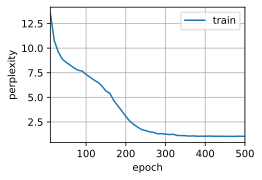

In [82]:
train_ch8(net, train_iter, vocab, lr, num_epochs, try_gpu())

困惑度：1.39, 92642.22标记/秒, cuda:0
time traveller held in his hand was a glitteringmetallic framewo
traveller for so it will be convenient to speak of himwas e


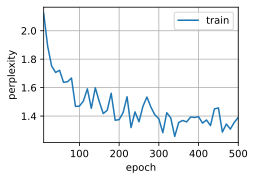

In [83]:
train_ch8(net, train_iter, vocab, lr, num_epochs, 
          try_gpu(), use_random_iter = True)

In [84]:
# 6.循环神经网络的简介实现
import torch
from torch import nn
from torch.nn import functional as F

In [86]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [87]:
# 定义模型
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [88]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [89]:
x = torch.rand(size = (num_steps, batch_size, len(vocab)))
y, state_new = rnn_layer(x, state)
y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [100]:
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(
                self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear - nn.Linear(
                self.num_hiddens * 2, self.vocab_size)
    def forward(self, inputs, state):
        x = F.one_hot(inputs.T.long(), self.vocab_size)
        x = x.to(torch.float32)
        # 全连接层首先将 y 的形状改为 时间步数 * 批量大小，隐藏单元
        y, state = self.rnn(x, state)
        # 输出形状为 时间步数 * 批量大小，此表大小
        output = self.linear(y.reshape((-1, y.shape[-1])))
        return output, state
    def begin_state(self, device, batch_size = 1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros(
                (self.num_directions * self.rnn.num_layers, 
                 batch_size, self.num_hiddens), device = device)
        else:
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers, 
                bath_size, self.num_hiddens), device = device), 
                    torch.zeros(
                        (self.num_directions * self.rnn.num_layers,
                         bath_size, self.num_hiddens), 
                        device = device))

In [101]:
# 训练与预测
device = try_gpu()
net = RNNModel(rnn_layer, vocab_size = len(vocab))
net = net.to(device)

In [102]:
predict_ch8('time traveller', 10, net, vocab, device)

'time travellerfftttttttt'

困惑度：1.30, 230348.91标记/秒, cuda:0
time traveller fother ghte inlensand his is bowk aby che dinde w
travellerickt rowhther calo athe that thime dimension with 


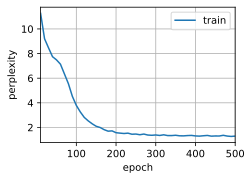

In [104]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)